## Text Summarization with seq2seq model

In [1]:
import numpy as np
import pandas as pd

In [2]:
summary = pd.read_csv('news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
print(summary)
print(raw)

                  author                   date  \
0           Chhavi Tyagi   03 Aug 2017,Thursday   
1            Daisy Mowke   03 Aug 2017,Thursday   
2         Arshiya Chopra   03 Aug 2017,Thursday   
3          Sumedha Sehra   03 Aug 2017,Thursday   
4     Aarushi Maheshwari   03 Aug 2017,Thursday   
...                  ...                    ...   
4509      Mansha Mahajan     24 Feb 2017,Friday   
4510      Dishant Sharma   03 Aug 2017,Thursday   
4511       Tanya Dhingra   03 Aug 2017,Thursday   
4512      Pragya Swastik  07 Dec 2016,Wednesday   
4513        Chhavi Tyagi   03 Aug 2017,Thursday   

                                              headlines  \
0     Daman & Diu revokes mandatory Rakshabandhan in...   
1     Malaika slams user who trolled her for 'divorc...   
2     'Virgin' now corrected to 'Unmarried' in IGIMS...   
3     Aaj aapne pakad liya: LeT man Dujana before be...   
4     Hotel staff to get training to spot signs of s...   
...                              

In [4]:
pre1 =  raw.iloc[:,0:2].copy()
pre2 = summary.iloc[:,0:6].copy()
pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep = " "), sep =" "),sep= " "), sep = " ")

In [5]:
pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'],pre2['headlines']],ignore_index = True)

In [7]:
import re

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row

In [8]:
brief_cleaning1 = text_strip(pre['text'])
brief_cleaning2 = text_strip(pre['summary'])

In [9]:
#!pip uninstall murmurhash
#!pip uninstall spacy


In [10]:
#! pip install -U spacy

In [11]:
#!pip install -U pip setuptools wheel

In [12]:
from time import time
import spacy
from spacy.cli.download import download
download(model="en_core_web_sm")
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
Time to clean up everything: 7.86 mins


In [13]:


t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.53 mins


In [14]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)
text_count = []
summary_count = []
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

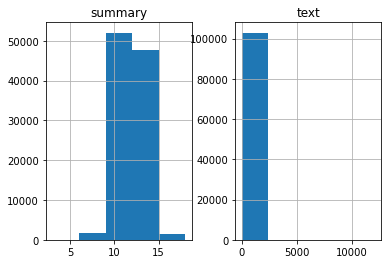

In [15]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [16]:
#Check how much % of summary have 0-15 words
cnt=0
for i in pre['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(pre['cleaned_summary']))

0.9978234465335472


In [17]:
#Check how much % of text have 0-70 words
cnt=0
for i in pre['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

0.9578389933440218


In [18]:
max_text_len=100
max_summary_len=15

In [19]:
cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [20]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [21]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [22]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

Using TensorFlow backend.


In [23]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 57.91270391131826
Total Coverage of rare words: 1.3404923996005096


In [24]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 33412


In [25]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [26]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.34503603813067
Total Coverage of rare words: 3.566630093901333


In [27]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 11581


In [28]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [29]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [30]:
!pip install -U gensim

Requirement already up-to-date: gensim in /opt/conda/lib/python3.6/site-packages (4.2.0)


In [31]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()
model.save("main_model_first.h5")

Size of vocabulary from the w2v model = 33412
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     6682400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
________________________________________________

In [32]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [33]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 88517 samples, validate on 9836 samples
Epoch 1/50
88517/88517 [==============================] - 360s 4ms/sample - loss: 5.0963 - val_loss: 4.7943
Epoch 2/50
88517/88517 [==============================] - 354s 4ms/sample - loss: 4.7188 - val_loss: 4.5428
Epoch 3/50
88517/88517 [==============================] - 352s 4ms/sample - loss: 4.4723 - val_loss: 4.3459
Epoch 4/50
88517/88517 [==============================] - 352s 4ms/sample - loss: 4.2912 - val_loss: 4.2073
Epoch 5/50
88517/88517 [==============================] - 354s 4ms/sample - loss: 4.1543 - val_loss: 4.0907
Epoch 6/50
88517/88517 [==============================] - 351s 4ms/sample - loss: 4.0465 - val_loss: 4.0074
Epoch 7/50
88517/88517 [==============================] - 345s 4ms/sample - loss: 3.9553 - val_loss: 3.9345
Epoch 8/50
88517/88517 [==============================] - 349s 4ms/sample - loss: 3.8732 - val_loss: 3.8727
Epoch 9/50
88517/88517 [==============================] - 356s 4ms/sample - loss: 3.801

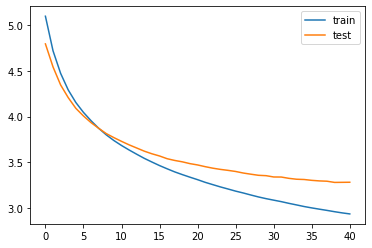

In [34]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [35]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [36]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
encoder_model.save("encoder_model_first.h5")

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])
decoder_model.save("decoder_model_first.h5")

In [37]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [38]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [39]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: pope francis on tuesday called for respect for each ethnic group in speech delivered in myanmar avoiding reference to the rohingya minority community as the nation works to restore peace the healing of wounds must be priority he said the pope myanmar visit comes amid the country military crackdown resulting in the rohingya refugee crisis 
Original summary: start pope avoids mention of rohingyas in key myanmar speech end 
Predicted summary:  start pope urges people to withdraw from rohingya refugees end


Review: students of government school in uttar pradesh sambhal were seen washing dishes at in school premises on being approached basic shiksha adhikari virendra pratap singh said yes have also received this complaint from elsewhere we are inquiring and action will be taken against those found guilty 
Original summary: start students seen washing dishes at govt school in up end 
Predicted summary:  start students protest after school bus service in up end


Review: apple india 

Predicted summary:  start only person to be called for name end


Review: actor shahid kapoor while speaking about ranveer singh portrayal of alauddin khilji in the film padmaavat said he would have played the character differently we are two different actors and our style of acting is different he added earlier ranveer had said he would have played shahid character in the film better than shahid 
Original summary: start i would have played khilji differently shahid kapoor end 
Predicted summary:  start i am to play in my film shahid on padmavati row end


Review: minors cannot opt out of aadhaar after turning 18 year old since it not permissible under the aadhaar act uidai has told the supreme court they can lock their biometrics permanently and can unlock it temporarily if needed for biometric authentication further the sc was told the biometrics failure rate at the national level was 6 for fingerprints and 8 54 for iris 
Original summary: start minors can opt out of aadhaar after tu

Predicted summary:  start google to not allow users to live in videos report end


Review: india is model for peacefully resolving maritime disputes and strong provider of security us navy secretary richard spencer has said praising india for peacefully resolving maritime border dispute with the us in the indo pacific region the relationship between the us and india is based on our shared values and desire to preserve peace the us official added 
Original summary: start india model for maritime disputes us end 
Predicted summary:  start india has nothing for us in india us end


Review: the archaeological site rani ki vav that features on the rear of new ã¢ââ¹100 notes is unesco world heritage site in gujarat patan the 11th century site is which was built by the solanki dynasty queen as memorial for her deceased husband in 2016 it was awarded the cleanest iconic place in india title 
Original summary: start what is the importance of rani ki featured on new ã¢ââ¹100 note end 
Predicte

Predicted summary:  start new trailer of deepika padukone starrer released end


Review: the archaeological survey of india asi has banned selfie sticks at its 46 site museums across the country including taj museum in agra and indian war memorial museum in delhi further the visitors would need to get permission for using flash multiple lenses and carrying large photography bags 15 days before the scheduled visit 
Original summary: start selfie sticks banned at 46 site across india end 
Predicted summary:  start india bans use of gay people in mumbai end


Review: indian commodity exchange on monday commenced operations as the world first diamond futures exchange indian manufacturers most require this type of financial product md prasad said adding shall offer fair transparent and nationwide market bringing in large market participation into diamond trade the exchange is backed by companies like reliance capital and 
Original summary: start worldã¢ââs 1st diamond futures exchange sta

Predicted summary:  start hc notice to states over fake news on social media end


Review: an 80 year old woman threw coins into the engine of plane at shanghai airport for good luck on tuesday all 150 passengers were evacuated and the flight was delayed for nearly six hours after one of the nine coins she threw entered the engine the woman has been exempted from jail because she is aged over 70 the police said 
Original summary: start woman throws coins into plane engine for luck delays flight end 
Predicted summary:  start woman falls off flight after being hit by train end


Review: actress margot best known for playing the role of lois lane in the superman film franchise of the 1970s and 1980s passed away on sunday at the age of 69 an autopsy will be performed to determine the cause of her death margot who suffered from car accident in 1990 had experienced long term mental health issues 
Original summary: start actress who portrayed lane in superman film passes away end 
Predicted 

Predicted summary:  start i don think about you don know how to do you end


Review: scientists have discovered the fossils of an elephant sized mammal that lived alongside dinosaurs during the triassic period about 200 million years ago named the four legged creature belonged to group of mammal like reptiles called we think itã¢ââs one of the most unexpected fossil discoveries from the triassic of europe one of the scientists said 
Original summary: start fossils of like reptile that lived with dinosaurs found end 
Predicted summary:  start scientists find new year old in dinosaur era end


Review: the german parliament lower house has approved draft law that partially bans the full face islamic veil for public servants including election officials military and judicial staff while at work the law however allows exceptions such as for health workers protecting themselves against infections or police officers concealing their identity it will now go to the upper house for approval 
O

In [40]:
decoder_model.save("decoder_model_first.h5")
model.save("main_model_first.h5")
encoder_model.save("encoder_model_first.h5")